In [225]:
# import packages

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
# import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

In [226]:
# import data

data = pd.read_csv('data/kc_house_data.csv')

In [227]:
# Column Names and descriptions for Kings County Data Set
# * **id** - unique identified for a house
# * **date** - house was sold
# * **price** -  is prediction target
# * **bedrooms** -  of Bedrooms/House
# * **bathrooms** -  of bathrooms/bedrooms
# * **sqft_living** -  footage of the home
# * **sqft_lot** -  footage of the lot
# * **floors** -  floors (levels) in house
# * **waterfront** - House which has a view to a waterfront
# * **view** - Has been viewed
# * **condition** - How good the condition is ( Overall )
# * **grade** - overall grade given to the housing unit, based on King County grading system
# * **sqft_above** - square footage of house apart from basement
# * **sqft_basement** - square footage of the basement
# * **yr_built** - Built Year
# * **yr_renovated** - Year when house was renovated
# * **zipcode** - zip
# * **lat** - Latitude coordinate
# * **long** - Longitude coordinate
# * **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
# * **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [228]:
# stakeholder: real estate agent who wants to sell homes
# Agent needs to explain to sellers what their homes will sell for, how to price them
# price will be target variable

In [229]:
# explore data

data.head()
data.info()
data.describe()

# questions and observations:
# high outliers in price, bedrooms, bathrooms, sqft_living, sqft_lot, & grade
# null values in waterfront, view, yr_renovated
# waterfront has lots of 0s
# turn date (sale date) into a date
# turn sqft_basement into a float (but noticed it has some non-number values, like ?)
# view (number of times house has been viewed), lat, and long are probably not relevant

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000,19221.00000,21534.00000,21597.00000,21597.00000,21597.00000,21597.00000,17755.00000,21597.00000,21597.00000,21597.00000,21597.00000,21597.00000
mean,4580474287.77099,540296.57351,3.37320,2.11583,2080.32185,15099.40876,1.49410,0.00760,0.23386,3.40983,7.65792,1788.59684,1970.99968,83.63678,98077.95185,47.56009,-122.21398,1986.62032,12758.28351
std,2876735715.74778,367368.14010,0.92630,0.76898,918.10613,41412.63688,0.53968,0.08682,0.76569,0.65055,1.17320,827.75976,29.37523,399.94641,53.51307,0.13855,0.14072,685.23047,27274.44195
min,1000102.00000,78000.00000,1.00000,0.50000,370.00000,520.00000,1.00000,0.00000,0.00000,1.00000,3.00000,370.00000,1900.00000,0.00000,98001.00000,47.15590,-122.51900,399.00000,651.00000
25%,2123049175.00000,322000.00000,3.00000,1.75000,1430.00000,5040.00000,1.00000,0.00000,0.00000,3.00000,7.00000,1190.00000,1951.00000,0.00000,98033.00000,47.47110,-122.32800,1490.00000,5100.00000
50%,3904930410.00000,450000.00000,3.00000,2.25000,1910.00000,7618.00000,1.50000,0.00000,0.00000,3.00000,7.00000,1560.00000,1975.00000,0.00000,98065.00000,47.57180,-122.23100,1840.00000,7620.00000
75%,7308900490.00000,645000.00000,4.00000,2.50000,2550.00000,10685.00000,2.00000,0.00000,0.00000,4.00000,8.00000,2210.00000,1997.00000,0.00000,98118.00000,47.67800,-122.12500,2360.00000,10083.00000
max,9900000190.00000,7700000.00000,33.00000,8.00000,13540.00000,1651359.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77760,-121.31500,6210.00000,871200.00000


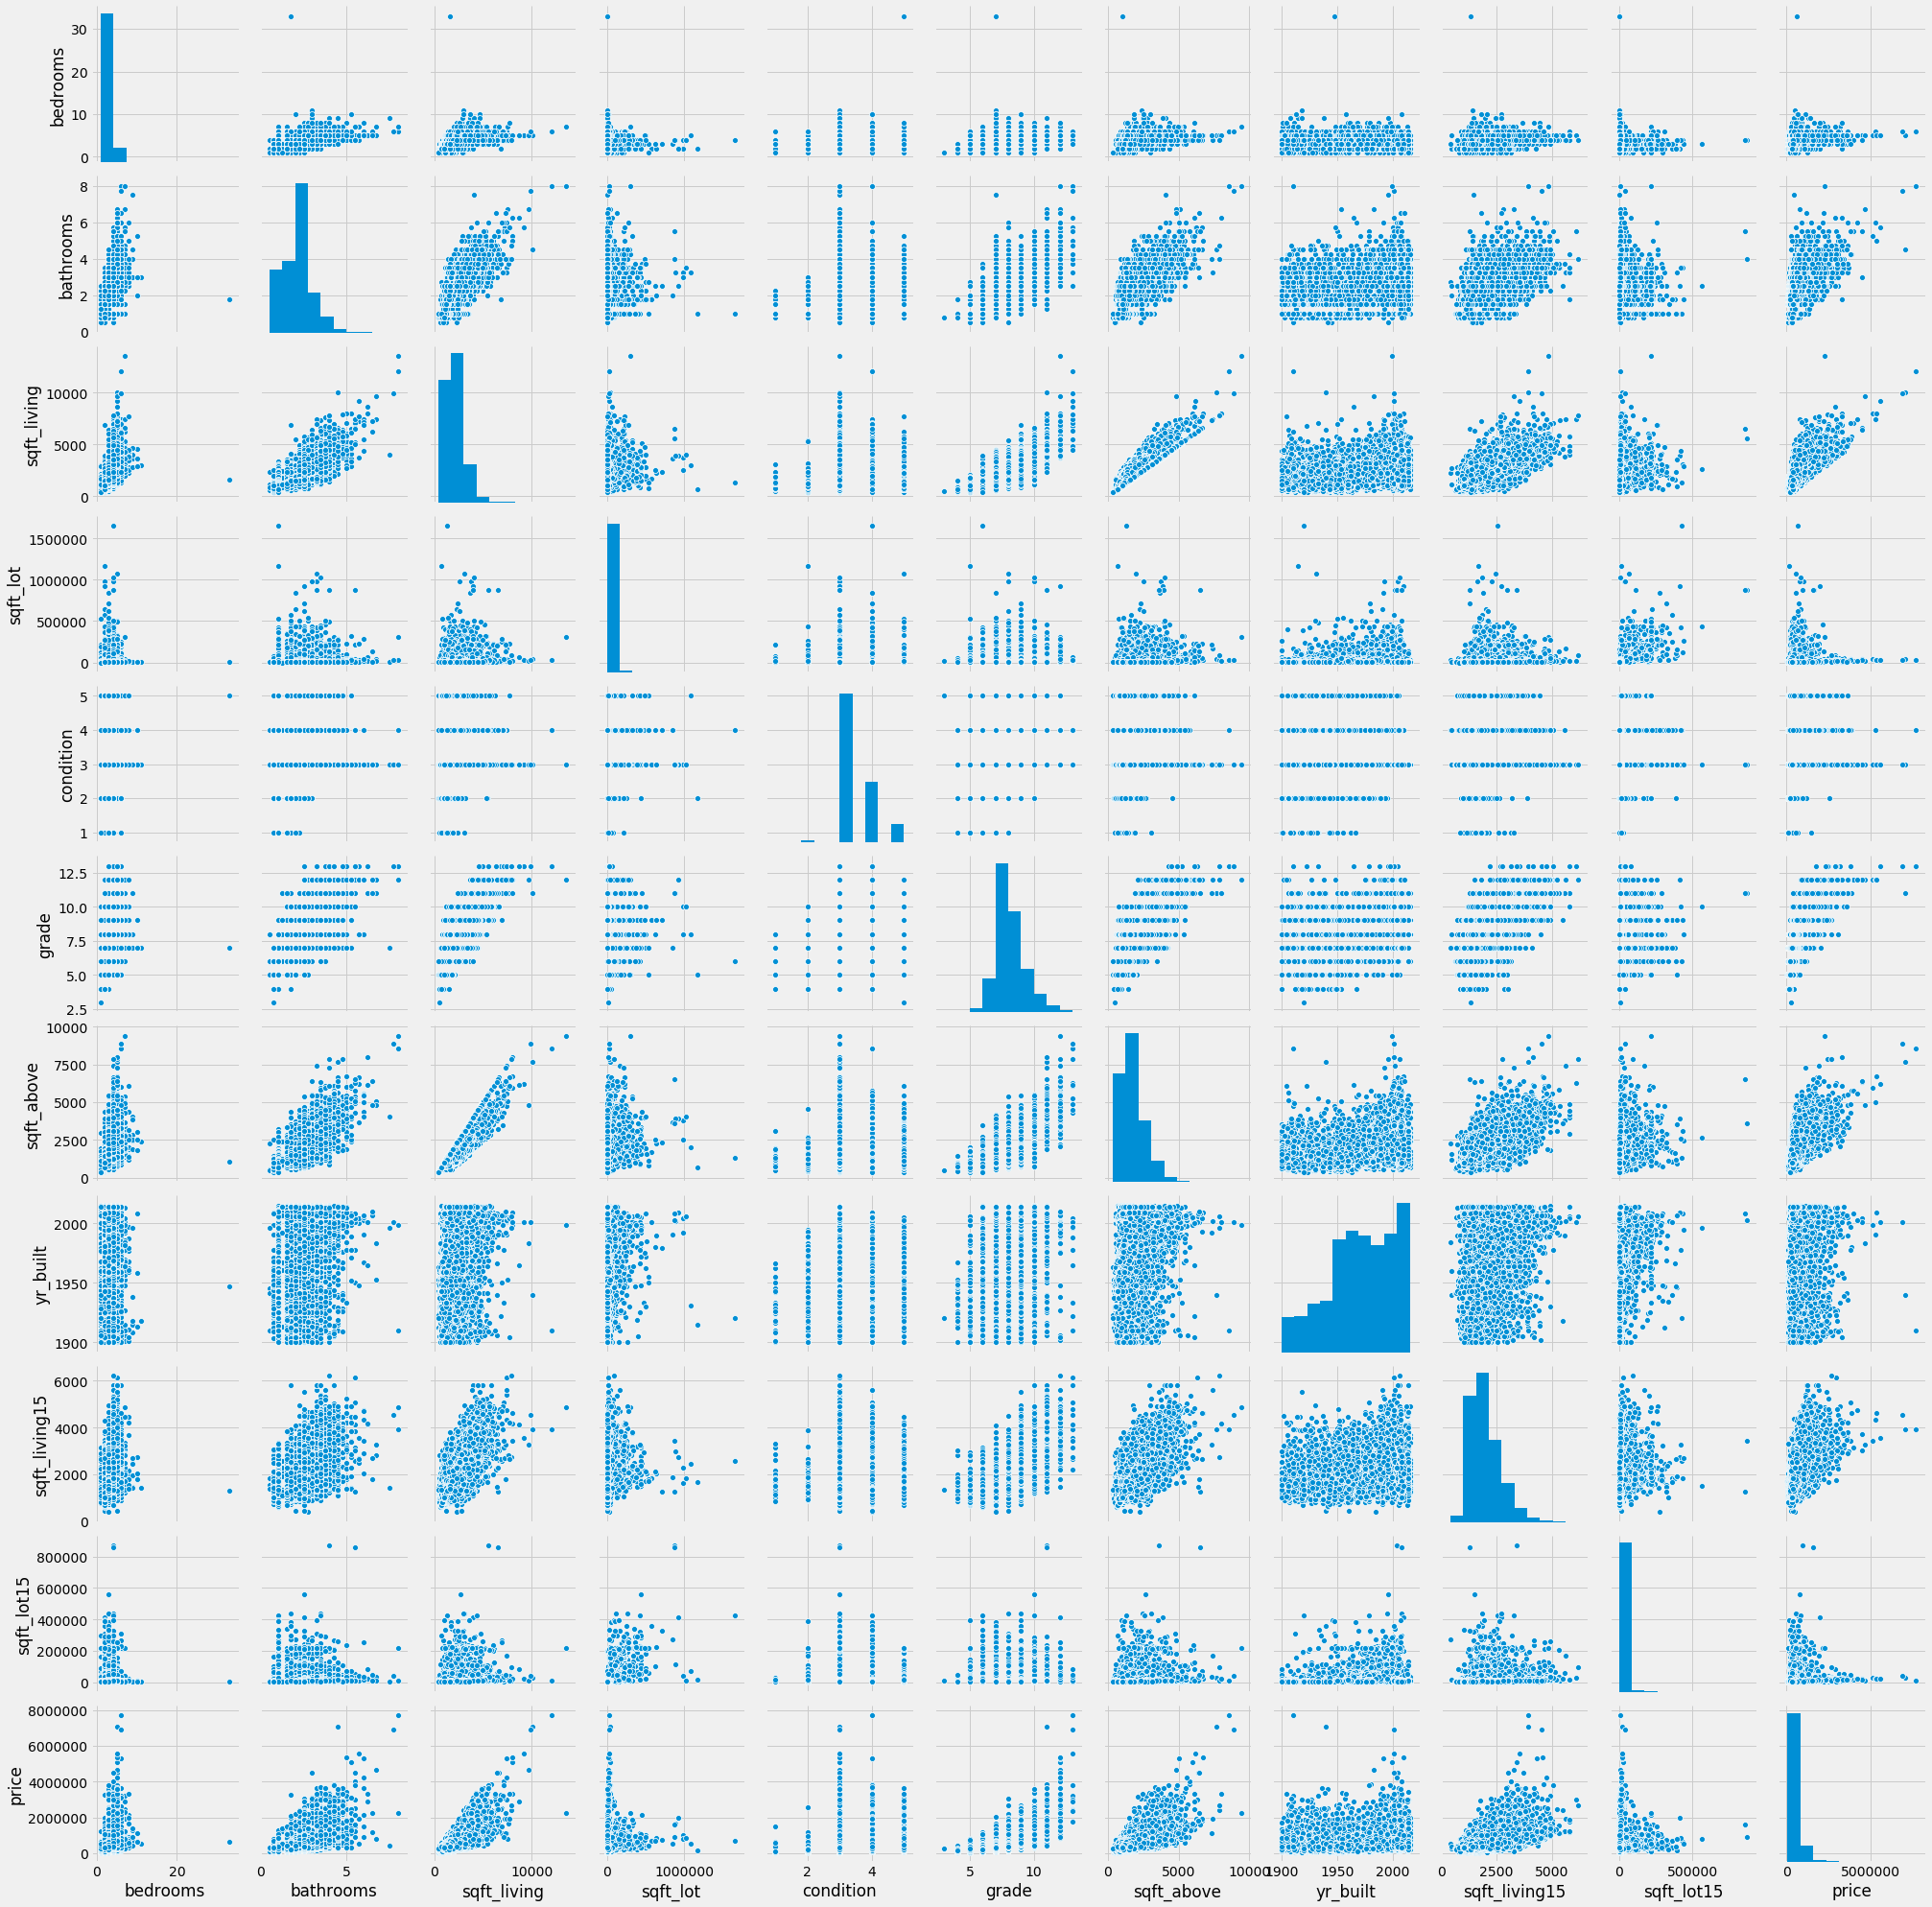

In [230]:
# explore data
# let's try a pairplot to see if anything stands out

cols_of_interest = [ 
                    'bedrooms', 
                    'bathrooms', 
                    'sqft_living',
                    'sqft_lot', 
                    'condition', 
                    'grade', 
                    'sqft_above',
                    'yr_built',  
                    'sqft_living15', 
                    'sqft_lot15',
                    'price']

sns.pairplot(data[cols_of_interest]);

# strongest correlations with price appear to be sqft_living, sqft_above, sqft_living15, grade, bathrooms
# strong correlations between X variables are among these same columns
# all five are correlated with each other
# this multicollinearity could be problematic

# nothing looks normally distributed except maybe grade and bedrooms
# bathrooms, sqft_living, sqft_above, sqft_living15 may be approaching a normal distribution

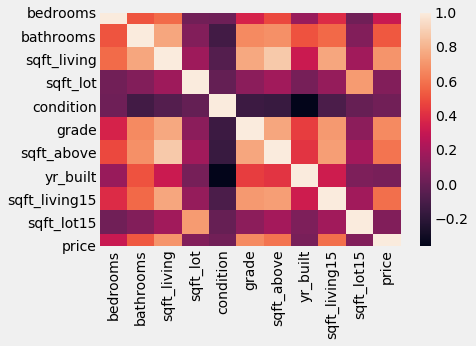

In [231]:
# let's make a heatmap to be sure

sns.heatmap(data[cols_of_interest].corr())

# yes, confirms the observations above

In [232]:
# let's look at the numbers

data[cols_of_interest].corr()

# sqft_living is the best predictor of price so far

,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price
bedrooms,1.00000,0.51451,0.57821,0.03247,0.02650,0.35656,0.47939,0.15567,0.39341,0.03069,0.30879
bathrooms,0.51451,1.00000,0.75576,0.08837,-0.12648,0.66584,0.68667,0.50717,0.56988,0.08830,0.52591
sqft_living,0.57821,0.75576,1.00000,0.17345,-0.05944,0.76278,0.87645,0.31815,0.75640,0.18434,0.70192
sqft_lot,0.03247,0.08837,0.17345,1.00000,-0.00883,0.11473,0.18414,0.05295,0.14476,0.71820,0.08988
condition,0.02650,-0.12648,-0.05944,-0.00883,1.00000,-0.14690,-0.15890,-0.36159,-0.09307,-0.00313,0.03606
grade,0.35656,0.66584,0.76278,0.11473,-0.14690,1.00000,0.75607,0.44787,0.71387,0.12098,0.66795
sqft_above,0.47939,0.68667,0.87645,0.18414,-0.15890,0.75607,1.00000,0.42404,0.73177,0.19508,0.60537
yr_built,0.15567,0.50717,0.31815,0.05295,-0.36159,0.44787,0.42404,1.00000,0.32638,0.07078,0.05395
sqft_living15,0.39341,0.56988,0.75640,0.14476,-0.09307,0.71387,0.73177,0.32638,1.00000,0.18352,0.58524
sqft_lot15,0.03069,0.08830,0.18434,0.71820,-0.00313,0.12098,0.19508,0.07078,0.18352,1.00000,0.08284


In [233]:
# let's look just at the correlations with price

data[cols_of_interest].corr()['price'].sort_values(ascending=False)

# interesting, sqft_living is further above the rest than I thought

price           1.00000
sqft_living     0.70192
grade           0.66795
sqft_above      0.60537
sqft_living15   0.58524
bathrooms       0.52591
bedrooms        0.30879
sqft_lot        0.08988
sqft_lot15      0.08284
yr_built        0.05395
condition       0.03606
Name: price, dtype: float64

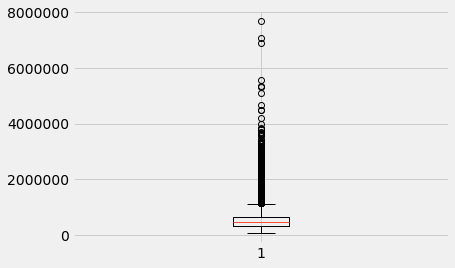

In [234]:
# investigate price outliers

plt.boxplot(data.price); # looks like outliers are probably accurate

In [235]:
# investigate price outliers

data_price_outliers = data.loc[data.price > 1000000].sort_values(by='price', ascending=False)
data_price_outliers.head(500)
data_price_outliers.describe()

# looks like max values for price, bathrooms, sqft_living & grade are accurate
# what about bedrooms (33?) and sqft_lot

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000,1309.00000,1452.00000,1458.00000,1458.00000,1458.00000,1458.00000,1193.00000,1458.00000,1458.00000,1458.00000,1458.00000,1458.00000
mean,4181277190.71879,1539314.12894,4.07202,3.17284,3803.32236,23357.15501,1.80864,0.07334,1.22383,3.47188,9.76406,3112.65981,1974.71948,241.27410,98069.14403,47.61726,-122.22320,3064.53704,18097.37723
std,2825942293.59474,629062.83540,0.90429,0.86422,1191.60190,57262.99824,0.48633,0.26079,1.52630,0.71042,1.21103,1130.86532,32.54915,651.49001,55.49510,0.06024,0.11421,850.09082,36883.66853
min,31000165.00000,1010000.00000,1.00000,1.00000,1330.00000,609.00000,1.00000,0.00000,0.00000,1.00000,6.00000,1040.00000,1900.00000,0.00000,98004.00000,47.32930,-122.45100,1050.00000,1224.00000
25%,1725059147.50000,1150000.00000,4.00000,2.50000,2982.50000,6918.25000,1.50000,0.00000,0.00000,3.00000,9.00000,2230.00000,1951.25000,0.00000,98027.00000,47.57410,-122.29100,2470.00000,6360.00000
50%,3625650100.00000,1330000.00000,4.00000,3.25000,3660.00000,10916.00000,2.00000,0.00000,0.00000,3.00000,10.00000,2915.00000,1985.00000,0.00000,98053.00000,47.62685,-122.22300,3000.00000,10498.00000
75%,6613001164.50000,1700000.00000,5.00000,3.50000,4370.00000,18797.50000,2.00000,0.00000,3.00000,4.00000,11.00000,3853.75000,2003.00000,0.00000,98112.00000,47.65250,-122.15800,3620.00000,16883.50000
max,9831200520.00000,7700000.00000,10.00000,8.00000,13540.00000,920423.00000,3.50000,1.00000,4.00000,5.00000,13.00000,9410.00000,2015.00000,2015.00000,98199.00000,47.77350,-121.73100,6210.00000,858132.00000


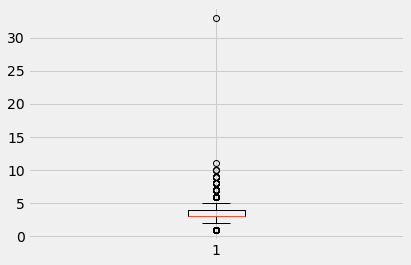

In [236]:
# investigate bedrooms outliers

plt.boxplot(data.bedrooms); # looks like there may be at least 1 inaccurate outlier

In [237]:
# investigate bedrooms outliers

data_br_outliers = data.loc[data.bedrooms > 5].sort_values(by='bedrooms', ascending=False)
data_br_outliers.head(20)

# looks like 33 bedrooms is an outlier due to small sqft_living and number of bathrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.00000,33,1.75000,1620,6000,1.00000,0.00000,0.00000,5,7,1040,580.0,1947,0.00000,98103,47.68780,-122.33100,1330,4700
8748,1773100755,8/21/2014,520000.00000,11,3.00000,3000,4960,2.00000,0.00000,0.00000,3,7,2400,600.0,1918,1999.00000,98106,47.55600,-122.36300,1420,4960
15147,5566100170,10/29/2014,650000.00000,10,2.00000,3610,11914,2.00000,0.00000,0.00000,4,7,3010,600.0,1958,0.00000,98006,47.57050,-122.17500,2040,11914
19239,8812401450,12/29/2014,660000.00000,10,3.00000,2920,3745,2.00000,0.00000,0.00000,4,7,1860,1060.0,1913,0.00000,98105,47.66350,-122.32000,1810,3745
13301,627300145,8/14/2014,1150000.00000,10,5.25000,4590,10920,1.00000,0.00000,2.00000,3,9,2500,2090.0,2008,0.00000,98004,47.58610,-122.11300,2730,10400
16830,8823900290,3/17/2015,1400000.00000,9,4.00000,4620,5508,2.50000,0.00000,0.00000,3,11,3870,750.0,1915,0.00000,98105,47.66840,-122.30900,2710,4320
4092,1997200215,5/7/2014,599999.00000,9,4.50000,3830,6988,2.50000,0.00000,0.00000,3,7,2450,1380.0,1938,0.00000,98103,47.69270,-122.33800,1460,6291
4231,2902200015,1/6/2015,700000.00000,9,3.00000,3680,4400,2.00000,0.00000,0.00000,3,7,2830,850.0,1908,0.00000,98102,47.63740,-122.32400,1960,2450
18428,8823901445,3/13/2015,934000.00000,9,3.00000,2820,4480,2.00000,0.00000,0.00000,3,7,1880,940.0,1918,0.00000,98105,47.66540,-122.30700,2460,4400
6073,9822700190,8/8/2014,1280000.00000,9,4.50000,3650,5000,2.00000,0.00000,0.00000,3,8,2530,1120.0,1915,2010.00000,98105,47.66040,-122.28900,2510,5000


In [238]:
# let's drop the row with 33 bedrooms

data = data.loc[data.bedrooms < 33]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 21 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       19220 non-null float64
view             21533 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null object
yr_built         21596 non-null int64
yr_renovated     17754 non-null float64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.6+ MB


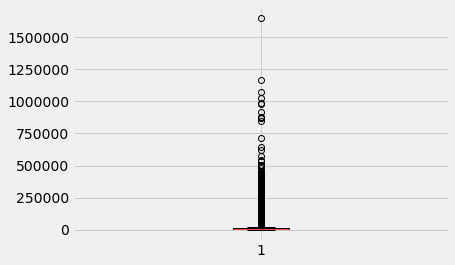

In [239]:
# investigate sqft_lot outliers

plt.boxplot(data.sqft_lot); # hard to say if the max value is inaccurate, let's look at it

In [240]:
# investigate sqft_lot outliers

data_lot_outliers = data.loc[data.sqft_lot > 500000].sort_values(by='sqft_lot', ascending=False)
data_lot_outliers.head(500)
# looks accurate.  checked out the first 3 zip codes and they are rural areas

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,1020069017,3/27/2015,700000.00000,4,1.00000,1300,1651359,1.00000,0.00000,3.00000,4,6,1300,0.0,1920,0.00000,98022,47.23130,-122.02300,2560,425581
17305,3326079016,5/4/2015,190000.00000,2,1.00000,710,1164794,1.00000,0.00000,0.00000,2,5,710,0.0,1915,0.00000,98014,47.68880,-121.90900,1680,16730
7640,2623069031,5/21/2014,542500.00000,5,3.25000,3010,1074218,1.50000,nan,0.00000,5,8,2010,1000.0,1931,0.00000,98027,47.45640,-122.00400,2450,68825
7762,2323089009,1/19/2015,855000.00000,4,3.50000,4030,1024068,2.00000,0.00000,0.00000,3,10,4030,0.0,2006,0.00000,98045,47.46190,-121.74400,1830,11700
3945,722069232,9/5/2014,998000.00000,4,3.25000,3770,982998,2.00000,0.00000,0.00000,3,10,3770,0.0,1992,0.00000,98058,47.41400,-122.08700,2290,37141
4437,3626079040,7/30/2014,790000.00000,2,3.00000,2560,982278,1.00000,0.00000,0.00000,3,8,2560,0.0,2004,0.00000,98014,47.69550,-121.86100,1620,40946
6685,2624089007,3/20/2015,2000000.00000,2,2.50000,3900,920423,2.00000,0.00000,0.00000,3,12,3900,0.0,2009,0.00000,98065,47.53710,-121.75600,2720,411962
7070,2724079090,1/5/2015,1650000.00000,4,3.25000,3920,881654,3.00000,nan,3.00000,3,11,3920,?,2002,nan,98024,47.53850,-121.89600,2970,112384
9705,225079036,1/7/2015,937500.00000,4,4.00000,5545,871200,2.00000,0.00000,0.00000,3,11,3605,1940.0,2003,0.00000,98014,47.67600,-121.88200,3420,871200
20436,1125079111,4/15/2015,1600000.00000,4,5.50000,6530,871200,2.00000,0.00000,2.00000,3,11,6530,0.0,2008,0.00000,98014,47.66400,-121.87800,1280,858132


In [241]:
# investigate null values in waterfront

data.waterfront.value_counts() # binary - 1 or 0
data.waterfront.isna().sum() #2376 null values out of 21596

# I'm reluctant to drop the rows, which are > 10% of the data
# For now I'll not include this column in the analysis
# But could also run a version with nan rows dropped to see if it's a significant predictor

2376

In [242]:
# deal with null values in yr_renovated

data['yr_renovated'].value_counts().head(50)
# 17010 values are 0
# nulls = data['yr_renovated'].isna().sum() #3842 values are null
# many of the values with actual years are old, e.g. 1930's-1990's

0.00000       17010
2014.00000       73
2003.00000       31
2013.00000       31
2007.00000       30
2000.00000       29
2005.00000       29
1990.00000       22
2004.00000       22
2009.00000       21
1989.00000       20
2006.00000       20
2002.00000       17
1991.00000       16
1998.00000       16
1984.00000       16
1999.00000       15
2008.00000       15
2010.00000       15
2001.00000       15
1983.00000       15
2015.00000       14
1985.00000       14
1986.00000       14
1987.00000       14
1994.00000       14
1992.00000       13
1993.00000       12
1997.00000       12
1995.00000       12
1996.00000       11
1988.00000       11
1970.00000        9
2011.00000        9
1980.00000        8
1982.00000        8
2012.00000        8
1979.00000        7
1977.00000        7
1968.00000        7
1975.00000        5
1964.00000        5
1969.00000        4
1963.00000        4
1973.00000        4
1981.00000        4
1965.00000        4
1978.00000        3
1960.00000        3
1958.00000        3


In [243]:
# create a new column showing homes renovated or not

data['renovated'] = np.where(data['yr_renovated'] > 0, 1, 0)
data['renovated'].value_counts() # only 744 homes show a year renovated

0    20852
1      744
Name: renovated, dtype: int64

In [244]:
# deal with non-number values in sqft_basement
data['sqft_basement'].value_counts() # continuous variable, but has 454 '?' values
# also 12826 0 values.  Do these homes truly not have basements?

# per cent of data that is missing:
missing_sqft_basement = round((len(data.loc[data['sqft_basement'] == '?'])/len(data))*100, 2)
print(missing_sqft_basement, "% of basement data is missing")

# per cent of data that is zero:
missing_sqft_basement = round((len(data.loc[data['sqft_basement'] == '0.0'])/len(data))*100, 2)
print(missing_sqft_basement, "% of basement data is zero")

2.1 % of basement data is missing
59.39 % of basement data is zero


In [245]:
# for now, let's fill missing values with zero, since that's the median
# probably this data will not be a predictor, but let's check

#replace all '?' values with '0'
data.loc[data['sqft_basement'] == '?', 'sqft_basement'] = '0'

data['sqft_basement'].value_counts().head(20)

0.0       12826
0           454
600.0       217
500.0       209
700.0       208
800.0       201
400.0       184
1000.0      148
900.0       142
300.0       142
200.0       105
750.0       104
530.0       103
480.0       103
450.0       103
720.0        98
620.0        90
840.0        83
580.0        83
420.0        81
Name: sqft_basement, dtype: int64

In [246]:
# now convert sqft_basement values to integers

data['sqft_basement'] = pd.to_numeric(data['sqft_basement'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 22 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       19220 non-null float64
view             21533 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null float64
yr_built         21596 non-null int64
yr_renovated     17754 non-null float64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
renovated        21596 non-null int64
dtypes: float64(9), int64(12), objec

In [247]:
# let's make a baseline model
# let's review the columns to see which we can include in a baseline model

data.columns

# columns to exclude:
# 'id', 'date', 'waterfront', 'view', 'yr_renovated', 'lat', 'long'

# justification for column exclusion:
# id - the randomly assigned row id
# date - date sold, all are in 2014 or 2015.  May investigate impact of month later
# waterfront - many missing values.  May investigate later to see if it's a significant predictor
# view - number of times the home has been viewed - not relevant for pricing homes newly on the market
# yr_renovated - missing values.  Turned into binary column 'renovated'
# 'lat' and 'long' - latitude and longitude of house - easier to pull neighborhood with zipcode

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated'],
      dtype='object')

In [248]:
# first, split into test and training sets

from sklearn.model_selection import train_test_split

# including relevant columns:

X=data[['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built', 
       'zipcode',
       'sqft_living15', 
       'sqft_lot15', 
       'renovated']]

y=data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

15117 6479 15117 6479


In [249]:
# for our first model-less baseline, let's use the mean price
# start with training set

mean_price = y_train.mean()
y_pred_train = np.full(shape=(len(X_train), 1), fill_value=mean_price)

# check r2
from sklearn.metrics import r2_score
r2_baseline_train = round(r2_score(y_true=y_train, y_pred=y_pred_train), 6)

# check Root Mean Squared Error
from sklearn.metrics import mean_squared_error
rmse_baseline_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train)), 2)

print('Training Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_train, '\n',
      'Root Mean Squared Error:', rmse_baseline_train)

Training Data 
 Mean Price: 542220.91 
 R-Squared: 0.0 
 Root Mean Squared Error: 368792.96


In [250]:
# now let's calculate baseline r2 and RMSE for the test set

y_pred_test = np.full(shape=(len(X_test), 1), fill_value=mean_price)

r2_baseline_test = round(r2_score(y_true=y_test, y_pred=y_pred_test), 6)

rmse_baseline_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test)), 2)

print('Testing Data', '\n', 
      'Mean Price:', round(mean_price, 2), '\n', 
      'R-Squared:', r2_baseline_test, '\n',
      'Root Mean Squared Error:', rmse_baseline_test)

Testing Data 
 Mean Price: 542220.91 
 R-Squared: -0.000312 
 Root Mean Squared Error: 364036.95


In [251]:
# the mean is not a good predictor of price!
# the average error for the test set is about 2/3 of the mean price!

# let's fit a baseline regression model

# let's scale the data so we can evaluate a baseline model

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [252]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

y_hat_train = linreg.predict(X_train_scaled)
y_hat_test = linreg.predict(X_test_scaled)

r2_base_reg_train = round(r2_score(y_true=y_train, y_pred=y_hat_train), 2)
r2_base_reg_test = round(r2_score(y_true=y_test, y_pred=y_hat_test), 2)

rmse_base_reg_train = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train)), 2)
rmse_base_reg_test = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_base_reg_train, '\n',
      'Root Mean Squared Error:', rmse_base_reg_train,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_base_reg_test, '\n',
      'Root Mean Squared Error:', rmse_base_reg_test)


 Training Data 
 R-Squared: 0.63 
 Root Mean Squared Error: 224767.41

 Testing Data 
 R-Squared: 0.61 
 Root Mean Squared Error: 228498.39


In [253]:
# that's a little better, but the model still only explains about 40% of the variance

In [254]:
# run it in Statsmodels to double check

# why don't I have to scale it here? it does it for me? gets much worse when I do

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = sm.OLS(y_train, X_train, hasconst=True)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1966.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:20:44   Log-Likelihood:            -2.0773e+05
No. Observations:               15117   AIC:                         4.155e+05
Df Residuals:                   15103   BIC:                         4.156e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -5.051e+04   2613.876    -19.324      0.000   -5.56e+04   -4.54e+04
bathrooms      5.233e+04   4387.069     11.927      0.000    4.37e+04    6.09e+04
sqft_living     128.1400     24.583      5.213      0.000      79.954     176.326
sqft_lot          0.0273      0.060      0.457      0.648      -0.090       0.145
floors          3.22e+04   4709.684      6.837      0.000     2.3e+04    4.14e+04
condition      2.364e+04   3085.872      7.661      0.000    1.76e+04    2.97e+04
grade          1.272e+05   2806.662     45.325      0.000    1.22e+05    1.33e+05
sqft_above       28.0621     24.479      1.146      0.252     -19.920      76.044
sqft_basement    68.1300     24.346      2.798      0.005      20.409     115.851
yr_built      -3846.7604     84.781    -45.373      0.000   -4012.942   -3680.578
zipcode          67.8927      1.688     40.214      0.000      64.583      71.202
sqft_living15    45.7577      4.456     10.268      0.000      37.023      54.493
sqft_lot15       -0.6444      0.095     -6.752      0.000      -0.831      -0.457
renovated      4.633e+04   1.06e+04      4.360      0.000    2.55e+04    6.72e+04
==============================================================================
Omnibus:                    11317.197   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           570079.099
Skew:                           3.111   Prob(JB):                         0.00
Kurtosis:                      32.434   Cond. No.                     5.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

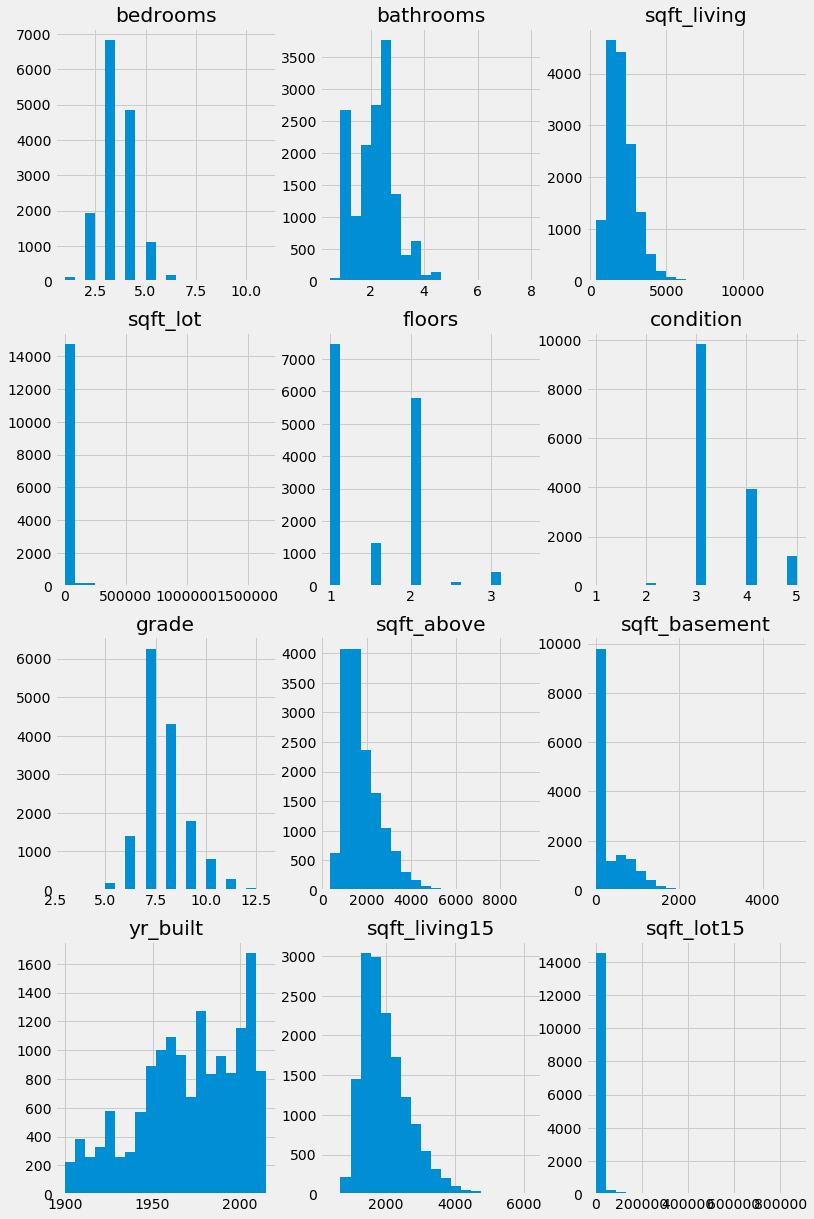

In [255]:
# let's look at the continuous variables.  Are they normally distributed?

continuous = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'sqft_basement', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

num_cols = 3
if len(continuous)%num_cols == 0:
    num_rows = len(continuous)//num_cols
else:
    num_rows = (len(continuous)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for c in continuous:
    axs[continuous.index(c)//num_cols, continuous.index(c)%num_cols].hist(X_train[c], bins=20)
    axs[continuous.index(c)//num_cols, continuous.index(c)%num_cols].set_title(c)

In [256]:
# let's try to log these and see if they become more normal
# don't include features with zeros, like sqft_basement

cont_non_zero = ['bedrooms', 
       'bathrooms', 
       'sqft_living', 
       'sqft_lot', 
       'floors', 
       'condition', 
       'grade',
       'sqft_above', 
       'yr_built',
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train_logged = X_train.copy()

for feat in cont_non_zero:
    X_train_logged[feat] = X_train_logged[feat].map(lambda x: np.log(x))


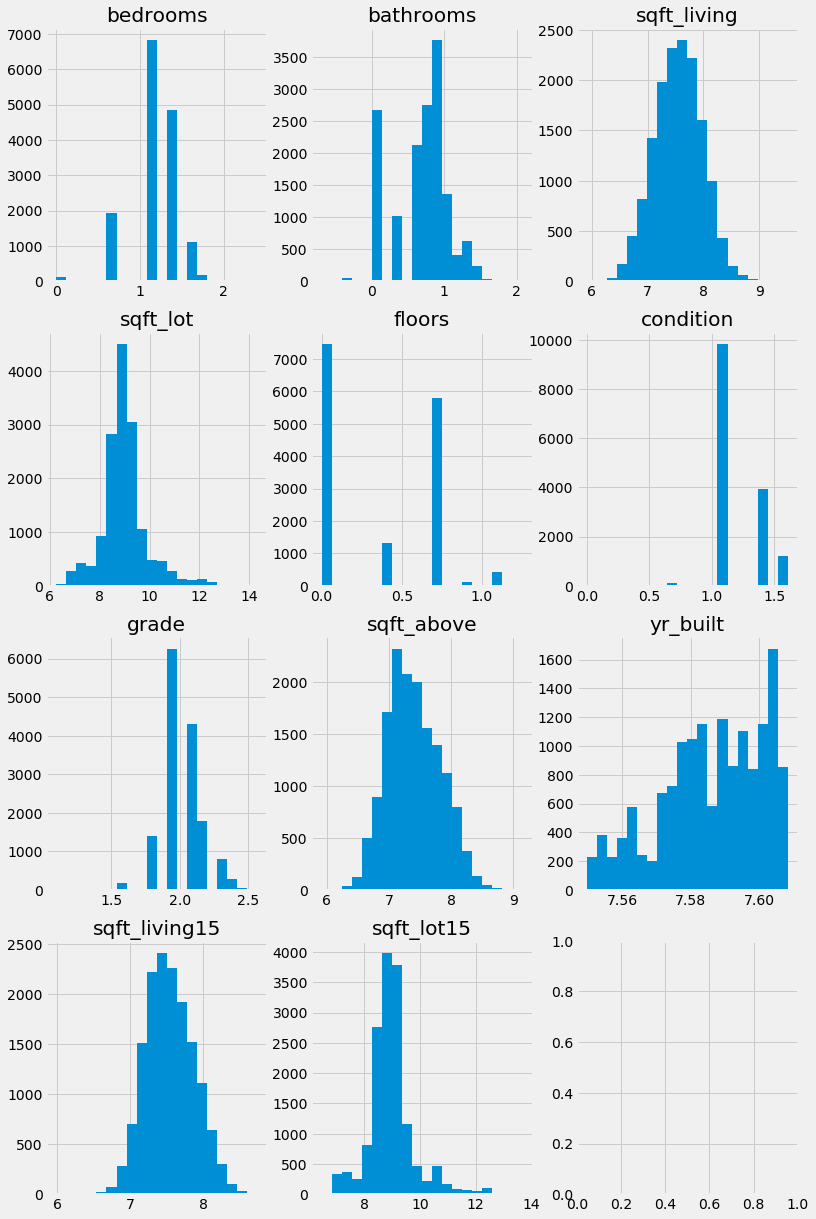

In [257]:
# Did it help?  Make more histograms?

num_cols = 3
if len(cont_non_zero)%num_cols == 0:
    num_rows = len(cont_non_zero)//num_cols
else:
    num_rows = (len(cont_non_zero)//num_cols)+1


fig, axs = plt.subplots(figsize=(12,20), nrows=num_rows, ncols=num_cols)


for c in cont_non_zero:
    axs[cont_non_zero.index(c)//num_cols, cont_non_zero.index(c)%num_cols].hist(X_train_logged[c], bins=20)
    axs[cont_non_zero.index(c)//num_cols, cont_non_zero.index(c)%num_cols].set_title(c)

In [258]:
# yeah, it kinda helped.  A bunch of things look more normal.
# like sqft_living, sqft_lot, grade, sqft_above, sqft_living15, sqft_lot15
# and to a lesser extent, bedrooms and grade too

In [259]:
# what if we build a model with just the above columns logged

# build a new X_train with just the above features logged

to_log = ['bedrooms', 
       'sqft_living', 
       'sqft_lot', 
       'grade',
       'sqft_above', 
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train_2 = X_train.copy()

for feat in to_log:
    X_train_2[feat] = X_train_2[feat].map(lambda x: np.log(x))

# scale the data so we can analyze the model

scaler2 = StandardScaler()
X_train_2_scaled = scaler2.fit_transform(X_train_2)

# log the test data

X_test_2 = X_test.copy()

for feat in to_log:
    X_test_2[feat] = X_test_2[feat].map(lambda x: np.log(x))

# scale the logged test data

X_test_2_scaled = scaler2.transform(X_test_2)


In [260]:
# now predict the test outcomes and get the r2 and RMSE scores

linreg2 = LinearRegression()
linreg2.fit(X_train_2_scaled, y_train)

y_hat_train2 = linreg2.predict(X_train_2_scaled)
y_hat_test2 = linreg2.predict(X_test_2_scaled)

r2_train2 = round(r2_score(y_true=y_train, y_pred=y_hat_train2), 2)
r2_test2 = round(r2_score(y_true=y_test, y_pred=y_hat_test2), 2)

rmse_train2 = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train2)), 2)
rmse_test2 = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test2)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_train2, '\n',
      'Root Mean Squared Error:', rmse_train2,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_test2, '\n',
      'Root Mean Squared Error:', rmse_test2)



 Training Data 
 R-Squared: 0.6 
 Root Mean Squared Error: 234324.43

 Testing Data 
 R-Squared: 0.55 
 Root Mean Squared Error: 243180.35


In [261]:
# oh no!  It didn't help!

In [262]:
# I am curious, what if I restrict the data to ONLY the normal columns

normal_col = ['bedrooms', 
       'sqft_living', 
       'sqft_lot', 
       'grade',
       'sqft_above', 
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train3 = X_train[normal_col]


In [263]:
# scale X_train3

scaler3 = StandardScaler()
X_train3_scaled = scaler3.fit_transform(X_train3)

# create the test set

X_test3 = X_test[normal_col]

# scale the test set

X_test3_scaled = scaler3.transform(X_test3)

# now predict the test outcomes and get the r2 and RMSE scores

linreg3 = LinearRegression()
linreg3.fit(X_train_3_scaled, y_train)

y_hat_train3 = linreg3.predict(X_train3_scaled)
y_hat_test3 = linreg3.predict(X_test3_scaled)

r2_train3 = round(r2_score(y_true=y_train, y_pred=y_hat_train3), 2)
r2_test3 = round(r2_score(y_true=y_test, y_pred=y_hat_test3), 2)

rmse_train3 = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train3)), 2)
rmse_test3 = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test3)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_train3, '\n',
      'Root Mean Squared Error:', rmse_train3,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_test3, '\n',
      'Root Mean Squared Error:', rmse_test3)


 Training Data 
 R-Squared: 0.56 
 Root Mean Squared Error: 245253.43

 Testing Data 
 R-Squared: 0.54 
 Root Mean Squared Error: 246797.89


In [264]:
# still worse.  So the other columns do add some value.

In [265]:
# these two features have the most improvement in normality after log transformations:
# sqft_living15
# sqft_lot15

# what if we just log these?

to_log = [
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train4 = X_train.copy()

for feat in to_log:
    X_train4[feat] = X_train4[feat].map(lambda x: np.log(x))

# scale the data so we can analyze the model

scaler4 = StandardScaler()
X_train4_scaled = scaler4.fit_transform(X_train4)

# log the test data

X_test4 = X_test.copy()

for feat in to_log:
    X_test4[feat] = X_test4[feat].map(lambda x: np.log(x))

# scale the logged test data

X_test4_scaled = scaler4.transform(X_test4)

# now predict the test outcomes and get the r2 and RMSE scores

linreg4 = LinearRegression()
linreg4.fit(X_train4_scaled, y_train)

y_hat_train4 = linreg4.predict(X_train4_scaled)
y_hat_test4 = linreg4.predict(X_test4_scaled)

r2_train4 = round(r2_score(y_true=y_train, y_pred=y_hat_train4), 2)
r2_test4 = round(r2_score(y_true=y_test, y_pred=y_hat_test4), 2)

rmse_train4 = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train4)), 2)
rmse_test4 = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test4)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_train4, '\n',
      'Root Mean Squared Error:', rmse_train4,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_test4, '\n',
      'Root Mean Squared Error:', rmse_test4)



 Training Data 
 R-Squared: 0.63 
 Root Mean Squared Error: 224497.44

 Testing Data 
 R-Squared: 0.61 
 Root Mean Squared Error: 227218.12


In [266]:
# wow!  That is a very slight improvement over the baseline model
# what if we log sqft_living and sqft_above also?

to_log = [
    'sqft_living',
    'sqft_above',
    'sqft_living15', 
    'sqft_lot15'
             ]

X_train5 = X_train.copy()

for feat in to_log:
    X_train5[feat] = X_train5[feat].map(lambda x: np.log(x))

# scale the data so we can analyze the model

scaler5 = StandardScaler()
X_train5_scaled = scaler5.fit_transform(X_train5)

# log the test data

X_test5 = X_test.copy()

for feat in to_log:
    X_test5[feat] = X_test5[feat].map(lambda x: np.log(x))

# scale the logged test data

X_test5_scaled = scaler5.transform(X_test5)

# now predict the test outcomes and get the r2 and RMSE scores

linreg5 = LinearRegression()
linreg5.fit(X_train5_scaled, y_train)

y_hat_train5 = linreg5.predict(X_train5_scaled)
y_hat_test5 = linreg5.predict(X_test5_scaled)

r2_train5 = round(r2_score(y_true=y_train, y_pred=y_hat_train5), 2)
r2_test5 = round(r2_score(y_true=y_test, y_pred=y_hat_test5), 2)

rmse_train5 = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train5)), 2)
rmse_test5 = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test5)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_train5, '\n',
      'Root Mean Squared Error:', rmse_train5,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_test5, '\n',
      'Root Mean Squared Error:', rmse_test5)


 Training Data 
 R-Squared: 0.62 
 Root Mean Squared Error: 228495.92

 Testing Data 
 R-Squared: 0.57 
 Root Mean Squared Error: 237458.05


In [267]:
# nope, worse.  Let's stick with X_train4!

In [268]:
# maybe I should have dealt with multicollinearity first
# let's see which variables are highly correlated

X_train.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated
bedrooms,1.00000,0.53055,0.59439,0.03576,0.18600,0.01999,0.36826,0.49468,0.30337,0.16055,-0.15511,0.40711,0.03585,0.01035
bathrooms,0.53055,1.00000,0.76205,0.08551,0.50315,-0.12394,0.67031,0.69094,0.28761,0.49933,-0.20021,0.57568,0.09168,0.04808
sqft_living,0.59439,0.76205,1.00000,0.17671,0.35335,-0.05851,0.76381,0.87710,0.43258,0.31922,-0.19986,0.76076,0.19682,0.04407
sqft_lot,0.03576,0.08551,0.17671,1.00000,-0.00298,-0.01441,0.11499,0.18383,0.02255,0.05254,-0.12982,0.14967,0.68888,0.00901
floors,0.18600,0.50315,0.35335,-0.00298,1.00000,-0.26191,0.45866,0.52349,-0.24078,0.48552,-0.06139,0.28069,-0.00777,0.00377
condition,0.01999,-0.12394,-0.05851,-0.01441,-0.26191,1.00000,-0.14567,-0.15851,0.16984,-0.36437,0.00744,-0.09375,-0.00529,-0.05455
grade,0.36826,0.67031,0.76381,0.11499,0.45866,-0.14567,1.00000,0.75759,0.16830,0.44454,-0.18722,0.71585,0.12906,0.01988
sqft_above,0.49468,0.69094,0.87710,0.18383,0.52349,-0.15851,0.75759,1.00000,-0.04584,0.42396,-0.26258,0.73537,0.20195,0.01474
sqft_basement,0.30337,0.28761,0.43258,0.02255,-0.24078,0.16984,0.16830,-0.04584,1.00000,-0.12782,0.07435,0.20433,0.02852,0.06358
yr_built,0.16055,0.49933,0.31922,0.05254,0.48552,-0.36437,0.44454,0.42396,-0.12782,1.00000,-0.35107,0.32634,0.07566,-0.20083


In [269]:
# find top correlations
# code from Flatiron Data Science course's Multicollinearity Lab

df=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)

In [270]:
df[(df.cc>.75) & (df.cc <1)]

# as expected, high correlations among these five variables
# let's drop sqft_living and see what happens

,cc
pairs,
"(sqft_living, sqft_above)",0.87710
"(sqft_living, grade)",0.76381
"(bathrooms, sqft_living)",0.76205
"(sqft_living, sqft_living15)",0.76076
"(sqft_above, grade)",0.75759


In [271]:
# iterated thru dropping all five variables
# the only one which didn't reduce r2 is sqft_above

X_train6 = X_train.drop(columns = ['sqft_above'])

# when you remove sqft_lot also (high p-value), model gets worse

In [272]:
# does it help my r2?

model = sm.OLS(y_train, X_train6, hasconst=True)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2129.
Date:                Thu, 14 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:20:49   Log-Likelihood:            -2.0774e+05
No. Observations:               15117   AIC:                         4.155e+05
Df Residuals:                   15104   BIC:                         4.156e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -5.056e+04   2613.486    -19.347      0.000   -5.57e+04   -4.54e+04
bathrooms      5.213e+04   4383.743     11.891      0.000    4.35e+04    6.07e+04
sqft_living     155.7611      4.876     31.944      0.000     146.203     165.319
sqft_lot          0.0286      0.060      0.478      0.632      -0.089       0.146
floors         3.272e+04   4687.821      6.980      0.000    2.35e+04    4.19e+04
condition      2.354e+04   3084.649      7.631      0.000    1.75e+04    2.96e+04
grade          1.272e+05   2806.599     45.335      0.000    1.22e+05    1.33e+05
sqft_basement    40.9467      5.518      7.421      0.000      30.131      51.762
yr_built      -3844.5240     84.760    -45.358      0.000   -4010.664   -3678.384
zipcode          67.8474      1.688     40.198      0.000      64.539      71.156
sqft_living15    46.0095      4.451     10.337      0.000      37.285      54.734
sqft_lot15       -0.6456      0.095     -6.765      0.000      -0.833      -0.459
renovated      4.632e+04   1.06e+04      4.359      0.000    2.55e+04    6.71e+04
==============================================================================
Omnibus:                    11325.135   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           571562.595
Skew:                           3.113   Prob(JB):                         0.00
Kurtosis:                      32.473   Cond. No.                     5.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [273]:
# if we log the two features from X_train4 and also drop sqft_above, does it help?

to_log = [
       'sqft_living15', 
       'sqft_lot15'
             ]

X_train7 = X_train6.copy()

for feat in to_log:
    X_train7[feat] = X_train7[feat].map(lambda x: np.log(x))

# scale the data so we can analyze the model

scaler7 = StandardScaler()
X_train7_scaled = scaler7.fit_transform(X_train7)

# drop the same column and log the test data

X_test7 = X_test.copy().drop(columns='sqft_above')

for feat in to_log:
    X_test7[feat] = X_test7[feat].map(lambda x: np.log(x))

# scale the logged test data

X_test7_scaled = scaler7.transform(X_test7)

# now predict the test outcomes and get the r2 and RMSE scores

linreg7 = LinearRegression()
linreg7.fit(X_train7_scaled, y_train)

y_hat_train7 = linreg7.predict(X_train7_scaled)
y_hat_test7 = linreg7.predict(X_test7_scaled)

r2_train7 = round(r2_score(y_true=y_train, y_pred=y_hat_train7), 2)
r2_test7 = round(r2_score(y_true=y_test, y_pred=y_hat_test7), 2)

rmse_train7 = round(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_hat_train7)), 2)
rmse_test7 = round(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_hat_test7)), 2)

print('\n', 'Training Data', '\n', 
      'R-Squared:', r2_train7, '\n',
      'Root Mean Squared Error:', rmse_train7,)

print('\n',
      'Testing Data', '\n', 
      'R-Squared:', r2_test7, '\n',
      'Root Mean Squared Error:', rmse_test7)



 Training Data 
 R-Squared: 0.63 
 Root Mean Squared Error: 224530.22

 Testing Data 
 R-Squared: 0.61 
 Root Mean Squared Error: 227278.32


In [ ]:
# nope, that's not better than X_train4

In [282]:
# let's try to deal with zipcode
X_train8 = X_train4.copy()

X_train8['zipcode'] = X_train8['zipcode'].apply(str)
# X_train8 = X_train8.to_string(columns=['zipcode']) #no

X_train8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 3372 to 15795
Data columns (total 14 columns):
bedrooms         15117 non-null int64
bathrooms        15117 non-null float64
sqft_living      15117 non-null int64
sqft_lot         15117 non-null int64
floors           15117 non-null float64
condition        15117 non-null int64
grade            15117 non-null int64
sqft_above       15117 non-null int64
sqft_basement    15117 non-null float64
yr_built         15117 non-null int64
zipcode          15117 non-null object
sqft_living15    15117 non-null float64
sqft_lot15       15117 non-null float64
renovated        15117 non-null int64
dtypes: float64(5), int64(8), object(1)
memory usage: 1.7+ MB


In [290]:
X_train8['zipcode'].value_counts().count() # 70 different zips
X_train8['zipcode'].value_counts()

# did a little research, 98112 seems to be an expensive neighborhood, at least in 2019
# also 98199 is up there
# https://www.seattlemet.com/home-and-real-estate/2019/03/the-top-12-neighborhoods-in-seattle-2019-edition

98103    443
98052    418
98038    402
98115    400
98117    380
98034    380
98042    376
98133    359
98023    357
98006    337
98118    331
98059    323
98058    315
98155    310
98027    309
98074    296
98033    293
98125    290
98056    283
98053    274
98075    263
98001    248
98126    245
98092    237
98144    232
98106    232
98116    229
98199    228
98029    226
98065    220
98122    214
98004    212
98112    203
98198    199
98055    198
98028    198
98008    198
98003    193
98040    193
98031    193
98178    190
98072    189
98168    189
98177    187
98146    186
98136    185
98166    185
98107    182
98030    170
98045    165
98105    164
98022    153
98108    143
98077    138
98019    134
98011    128
98119    127
98002    127
98005    119
98188    101
98014     97
98007     95
98032     84
98010     77
98070     76
98102     75
98109     72
98024     61
98148     44
98039     37
Name: zipcode, dtype: int64

In [ ]:
# sum price by zip



In [ ]:
# future tweaks

# group zipcodes by neighborhood, one-hot encode
# use feature selection methods?
# try to see if waterfront is a predictor?
# try homes renov in last 10 or 20 years (code below)

# use min/max scalar for binary columns?
# model with just continuous? - didn't work
# log them if not normal? done

# look for interactions?
# try different train/test splits
# look at month sold?
# if model predicts something, e.g. over a million, go to a different model?

In [ ]:
# let's make a binary column showing homes renovated in the last 10 years
# since the sale dates are from different years,
# the new column should look at the difference between year sold and year renovated

data['date'].value_counts() 
type(data['date'][0]) # sale dates are strings, must convert to dates

# create a new column for year sold
data['yr_sold'] = pd.to_datetime(data['date']).dt.year
data['yr_sold'].value_counts() # sale dates are from 2014 and 2015

# create a new column showing homes renovated in the last 10 years
data['renov_10_yrs'] = np.where(data['yr_sold']-data['yr_renovated'] < 10, 1, 0)
data['renov_10_yrs'].value_counts() # only 254 homes renovated in last 10 years

# when looking at this, do we need to exclude homes built in last 10 years?